In [1]:
import numpy as np
from matplotlib import pyplot as plt
from enum import Enum

Założenia algorytmu MC:
- gra podzielona jest na skończone epizody

- niezależnie od podejmowanych akcji epizod zawsze się kończy

- estymacje wartości stanów i zmiany polityki następują dopiero na koniec epizodu (wniosek: jeśli warunek 2 nie jest spełniony to algorytm może nie zadziałać)

- estymacja wartości stanu s = średnia z 'returns' obserwowanych po odwiedzeniu stanu s




In [2]:
class Action(Enum):
    N = (-1, 0)
    S = (1, 0)
    E = (0, 1)
    W = (0, -1)

(2,3) - row 2 col 3

Gridworld: 10x7 (10 cols, 7 rows)

Start: (3,0)

Terminal: (3,7)

Jeśli wiatr próbuje wynieść agenta poza planszę - jest wynoszony maksymalnie jak się da, czyli na krawędź.

In [9]:
wind = np.array([0,0,0,1,1,1,2,2,1,0])
map_actions = {"N":0, "S":1, "E":2, "W":3}
np.random.seed(420)

In [3]:
def take_action(s, a): # s - state, ex. (3,6), a - action, ex. N
    av = a.value
    new_s = (s[0] + av[0] - wind[s[1]], s[1] + av[1])
    # Limity wyjścia poza planszę
    if new_s[0] < 0:
        new_s = (0, new_s[1])
    if new_s[0] > 6:
        new_s = (6, new_s[1])
    if new_s[1] < 0:
        new_s = (new_s[0], 0)
    if new_s[1] > 9:
        new_s = (new_s[0], 9)
    
    # Jeśli agent poruszający się zgodnie z aktualną polityką nie zmieni
    # swojego położenia w jednym kroku, to nie zmieni go już nigdy (w przypadku MC exploring starts)
    # W przypadku eps-soft może je zmienić gdy wylosuje się inny ruch niż zgodny z polityką.
    stuck = False
    if s[0] == new_s[0] and s[1] == new_s[1]:
        stuck = True
        
    terminated = False
    if new_s == (3,7):
        terminated = True
    
    return new_s, stuck, terminated

In [4]:
# Random starting policy (deterministic!)
policy = [[np.random.choice(list(Action)) for i in range(10)] for j in range(7)]
# Q_table[akcja][wiersz][kolumna]
# N - 0, S - 1, E - 2, W - 3
Q_table = [[[0 for i in range(10)] for j in range(7)] for k in range(4)]
# Return trzyma tylko liczbę elementów z których brana jest średnia
# Q_table zawiera dotychczasową średnią. Średnia jest uaktualniana w oparciu o:
# (size * avg + new_value) / (size+1)
Returns = [[[0 for i in range(10)] for j in range(7)] for k in range(4)]

In [5]:
def find_greedy_action(Q, state):
    best_action = None
    max_val = float("-Inf")
    w = state[0]
    k = state[1]
    for a in Action:
        val = Q[map_actions[a.name]][w][k]
        if val>max_val:
            max_val = val
            best_action = a
    return best_action

## Monte Carlo

In [10]:
# Eps-soft on-policy first-visit Monte Carlo
def train_policy(n_episodes, eps = 0.1, gamma = 0.9, reward = -1, start = (3,0)):
    
    for e in range(n_episodes):
        # Play the episode and generate S0,A0,R1 ...
        S = []
        state = start
        A = []
        terminated = False
        #print("Game starts")
        i = 0
        new_eps = eps
        while not terminated:
            if np.random.random() < new_eps:
                action = np.random.choice(list(Action))
                S.append(state)
                A.append(action)
                #print("State ", i, " : ", state)
                #print("Action ", i, " : ", action)
                state, stuck, terminated = take_action(state, action)
            else:
                action = policy[state[0]][state[1]]
                S.append(state)
                A.append(action)
                #print("State ", i, " : ", state)
                #print("Action ", i, " : ", action)
                state, stuck, terminated = take_action(state, action)
            # If stuck, choose random action instead of following policy
            if stuck:
                new_eps = 1
            else:
                new_eps = eps
            i = i + 1
            if i > 1000:
                terminated = True
            
        
        # Update Q-table and policy
        #print("Game ended, updating...")
        G = 0
        for t in range(len(S) - 1, -1, -1):
            state = S[t]
            action = A[t]
            G = gamma * G + reward # reward = -1 always
            # print("Timestep: ", t, " , G = ", G)
            if state in S[0:t] and action in A[0:t]:
                continue
            n = Returns[map_actions[action.name]][state[0]][state[1]]
            Q_table[map_actions[action.name]][state[0]][state[1]] = (Q_table[map_actions[action.name]][state[0]][state[1]] * n + G) / (n+1)
            Returns[map_actions[action.name]][state[0]][state[1]] = n+1
            A_best = find_greedy_action(Q_table, state)
            policy[state[0]][state[1]] = A_best

In [7]:
# Parametry
eps = 0.1
reward = -1
gamma = 0.9
start = (3,0)

[0 0 0 1 1 1 2 2 1 0]
Random policy


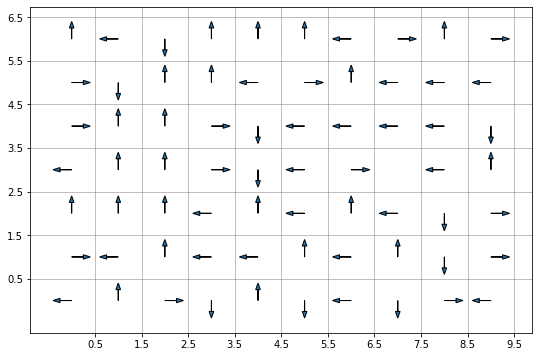

In [11]:
arrows = {"E":(1,0), "W":(-1,0),"N":(0,1),"S":(0,-1)}
scale = 0.25
fig, ax = plt.subplots(figsize=(9, 6))
for r, row in enumerate(policy):
    for c, cell in enumerate(row):
        if (r,c) == (3,7):
            continue
        
        plt.arrow(c, 6-r, scale*arrows[cell.name][0], scale*arrows[cell.name][1], head_width=0.1)
        

ax.set_xticks([i + 0.5 for i in range(len(policy[0]))])
ax.set_yticks([i + 0.5 for i in range(len(policy))])

ax.grid(True, which='both', color='gray', linewidth=1, linestyle='-', alpha=0.5)

print(wind)
print("Random policy")

In [12]:
print("At the beggining")
for action in [0,1,2,3]:
    print("Akcja ", action)
    for row in Q_table[action]:
        print(row)

At the beggining
Akcja  0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Akcja  1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Akcja  2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Akcja  3
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
train_policy(eps = eps, n_episodes = 500)

[0 0 0 1 1 1 2 2 1 0]
After 500 episodes


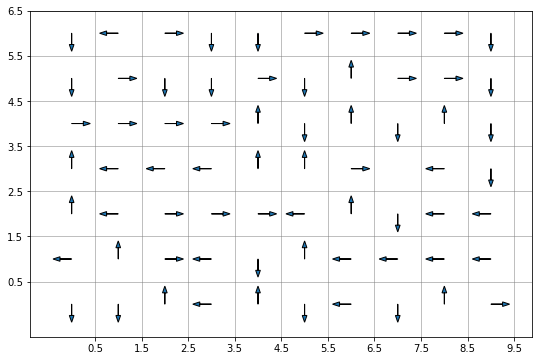

In [14]:
arrows = {"E":(1,0), "W":(-1,0),"N":(0,1),"S":(0,-1)}
scale = 0.25
fig, ax = plt.subplots(figsize=(9, 6))
for r, row in enumerate(policy):
    for c, cell in enumerate(row):
        if (r,c) == (3,7):
            continue
        
        plt.arrow(c, 6-r, scale*arrows[cell.name][0], scale*arrows[cell.name][1], head_width=0.1)
        

ax.set_xticks([i + 0.5 for i in range(len(policy[0]))])
ax.set_yticks([i + 0.5 for i in range(len(policy))])

ax.grid(True, which='both', color='gray', linewidth=1, linestyle='-', alpha=0.5)

print(wind)
print("After 500 episodes")

In [15]:
print("After 500 episodes")

def print_3d_array(Q_table):
    for i, grid in enumerate(Q_table):
        print(f"Akcja {list(map_actions.keys())[i]}:")
        for row in grid:
            for val in row:
                print(f"{val:.3f}", end=" "*(10-len(f"{val:.3f}")))
            print()  # Nowy wiersz
        print()  # Nowa linia między siatkami

print_3d_array(Q_table)

After 500 episodes
Akcja N:
-9.972    -9.945    -9.839    -9.851    -9.751    -8.726    -7.689    -7.510    -9.701    -9.173    
-9.949    -9.918    -9.964    -10.000   -9.110    -10.000   0.000     -8.063    -8.838    -9.506    
-9.664    -9.702    -9.784    -9.501    -10.000   -10.000   0.000     -10.000   -6.832    -6.643    
-9.251    -10.000   -10.000   -10.000   -9.996    0.000     0.000     0.000     -8.650    -6.626    
-9.593    -10.000   -10.000   -10.000   -10.000   0.000     0.000     -10.000   -7.393    -4.136    
-10.000   -10.000   -10.000   -10.000   -10.000   0.000     0.000     -10.000   -10.000   -9.806    
-10.000   -10.000   -10.000   -10.000   0.000     0.000     0.000     0.000     -1.900    -10.000   

Akcja S:
-9.714    -10.000   -9.984    -9.333    -8.811    -8.485    -9.549    -9.499    -8.133    -5.356    
-9.541    -10.000   -9.378    -9.859    -8.522    0.000     0.000     -9.939    -10.000   -4.779    
-9.646    -9.602    -9.927    -9.074    -10.000   0.0

## Wnioski:
- MC nie nadaje się do rozwiązania tego problemu, ponieważ szansa na to, że wykonując losowe ruchy dojdziemy do mety jest znikoma
<br/><br/>

- Zatem epizody są bardzo długie, często wcale się nie kończą, a Q-value prawie każdej odwiedzonej pary stan-akcja wynosi -10 bo po odwiedzeniu danego stanu agent błądził po planszy bez celu
<br/><br/>

- Barto i Sutton strona 130: "Note that Monte Carlo methods cannot easily be used here because termination is not guaranteed for all policies. If a policy was ever found that caused the agent to stay in the same state, then the next episode would never end."
<br/><br/>

- Ostatecznie po 500 epizodach algorytm zbiega do poprawnego rozwiązania, choć po 100 epizodach podejmował jeszcze prawie losowe akcje, nie prowadzące do wygranej

## Temporal Difference

Założenia o TD:
- algorytm TD nie musi czekać do końca epizodu aby ukatualnić swoją estymację wartości stanu V(s)
<br></br>
- reguła update'u: V(St) = V(St) + [R + gamma*V(St+1) - V(St)] * alpha, gdzie R + gamma*V(St+1) to nowa estymacja wartości obecnego stanu, alpha - parametr uczenia
<br></br>

- błąd estymacji w czasie t znamy dopiero w czasie t+1
<br></br>

- update polityki następuje od razu w momencie update'u wartości stanu (inaczej mówiąc akcja zawsze jest w stronę wyższego stanu, więc może się ona zmieniać w czasie epizodu) -> nie do końca jestem pewien czy to dobry tok myślenia, bo tego w książce nie było



In [41]:
def find_greedy_action_td(V, state):
    max_value = float("-Inf")
    best_action = None
    for a in Action:
        new_state,_,_ = take_action(state, a)
        value = V[new_state[0]][new_state[1]] # value of the new state, taking action a   
        if value > max_value:
            max_value = value
            best_action = a
    return best_action

In [114]:
# Eps-soft on-policy Temporal Difference lambda = 0 (one-step)
def train_policy_td(n_episodes, eps = 0.05, gamma = 0.9, reward = -1, start = (3,0), alpha = 0.5):
    episodes_count = 0 # For plot reproduction
    t = [0 for i in range(2000)]
    total_ts_count = 0
    for e in range(n_episodes):
        # Make estimates for current V_table, following policy V-greedy
        state = start
        terminated = False
        #print("Game starts")
        i = 0
        while not terminated:
            if np.random.random() < eps:
                action = np.random.choice(list(Action))
                #print("State ", i, " : ", state)
                #print("Action ", i, " : ", action)
                new_state, stuck, terminated = take_action(state, action)
                # Reward is always -1
                V_table_td[state[0]][state[1]] = V_table_td[state[0]][state[1]] + alpha * (-1 + gamma * V_table_td[new_state[0]][new_state[1]] - V_table_td[state[0]][state[1]])  
                state = new_state
            else:
                # Take action V-greedy - ?? (maybe it should still follow policy blindly)
                action = find_greedy_action_td(V_table_td, state)
                #print("State ", i, " : ", state)
                #print("Action ", i, " : ", action)
                new_state, stuck, terminated = take_action(state, action)
                V_table_td[state[0]][state[1]] = V_table_td[state[0]][state[1]] + alpha * (-1 + gamma * V_table_td[new_state[0]][new_state[1]] - V_table_td[state[0]][state[1]])
                state = new_state

                
            # If taking too long, end this suffering
            i = i + 1
            if total_ts_count < 2000:
                t[total_ts_count] = episodes_count
            total_ts_count = total_ts_count + 1
            if i > 1000:
                terminated = True
                
        episodes_count = episodes_count + 1
        
        # Update policy to match V-greedy policy
        #print("Game ended, updating policy")
        for i in range(7):
            for j in range(10):
                state = (i,j)
                if(state == (3,7)):
                    continue
                policy_td[i][j] = find_greedy_action_td(V_table_td, state)
    return t

In [62]:
# Parametry
eps = 0.1
reward = -1
gamma = 0.9
start = (3,0)
alpha = 0.5

In [93]:
# Random starting policy (deterministic!)
policy_td = [[np.random.choice(list(Action)) for i in range(10)] for j in range(7)]
# V_table[wiersz][kolumna]
V_table_td = [[0.0 for j in range(10)] for k in range(7)]

wind:  [0 0 0 1 1 1 2 2 1 0]
Random policy


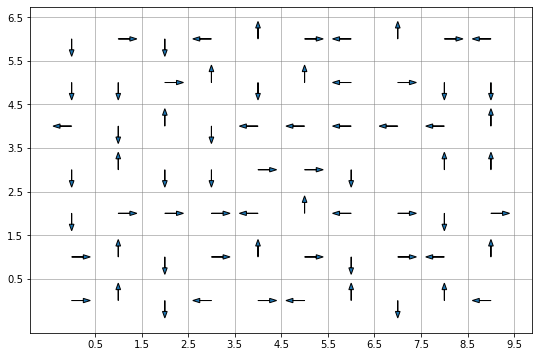

In [94]:
arrows = {"E":(1,0), "W":(-1,0),"N":(0,1),"S":(0,-1)}
scale = 0.25
fig, ax = plt.subplots(figsize=(9, 6))
for r, row in enumerate(policy_td):
    for c, cell in enumerate(row):
        if (r,c) == (3,7):
            continue
        
        plt.arrow(c, 6-r, scale*arrows[cell.name][0], scale*arrows[cell.name][1], head_width=0.1)
        

ax.set_xticks([i + 0.5 for i in range(len(policy_td[0]))])
ax.set_yticks([i + 0.5 for i in range(len(policy_td))])

ax.grid(True, which='both', color='gray', linewidth=1, linestyle='-', alpha=0.5)

print("wind: ", wind)
print("Random policy")

In [95]:
print("V_table at the beggining:")
for row in V_table_td:
    for val in row:
        print(f"{val:.3f}", end=" "*(10-len(f"{val:.3f}")))
    print()  # Nowy wiersz
print()  # Nowa linia między siatkami

V_table at the beggining:
0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     
0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     
0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     
0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     
0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     
0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     
0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.000     



In [96]:
train_policy_td(n_episodes=10)

wind:  [0 0 0 1 1 1 2 2 1 0]
Policy after 10 episodes


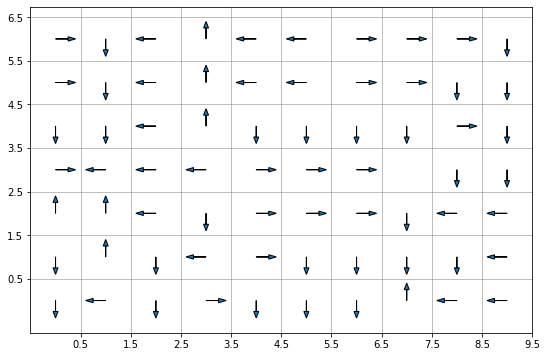

In [99]:
arrows = {"E":(1,0), "W":(-1,0),"N":(0,1),"S":(0,-1)}
scale = 0.25
fig, ax = plt.subplots(figsize=(9, 6))
for r, row in enumerate(policy_td):
    for c, cell in enumerate(row):
        if (r,c) == (3,7):
            continue
        
        plt.arrow(c, 6-r, scale*arrows[cell.name][0], scale*arrows[cell.name][1], head_width=0.1)
        

ax.set_xticks([i + 0.5 for i in range(len(policy_td[0]))])
ax.set_yticks([i + 0.5 for i in range(len(policy_td))])

ax.grid(True, which='both', color='gray', linewidth=1, linestyle='-', alpha=0.5)

print("wind: ", wind)
print("Policy after 10 episodes")

In [100]:
print("V_table after 10 episodes:")
for row in V_table_td:
    for val in row:
        print(f"{val:.3f}", end=" "*(10-len(f"{val:.3f}")))
    print()  # Nowy wiersz
print()  # Nowa linia między siatkami

V_table after 10 episodes:
-5.372    -5.204    -5.327    -5.316    -5.403    -5.505    -5.613    -5.401    -4.903    -4.412    
-5.240    -5.013    -5.324    -5.468    -5.518    -5.663    -5.302    -4.091    -4.341    -3.912    
-5.090    -4.923    -5.190    -5.479    -5.302    -4.901    -4.838    -3.147    -3.958    -3.342    
-4.923    -4.808    -5.094    -5.217    -5.158    -4.876    -4.528    0.000     -2.580    -2.673    
-5.114    -4.999    -5.018    -5.053    -5.135    -4.826    0.000     -2.084    -0.999    -1.891    
-5.012    -4.947    -5.118    -5.035    -4.922    0.000     0.000     -0.725    -0.750    -1.212    
-4.851    -5.050    -4.853    -5.214    0.000     0.000     0.000     0.000     -0.750    -1.100    



Po 10 epizodach jest niezły na finiszu, ale beznadziejny na starcie (prawdopodobnie ukończyłby epizod tylko dzięki eksploracji epsilonowej)

In [101]:
train_policy_td(n_episodes=90)

wind:  [0 0 0 1 1 1 2 2 1 0]
Policy after 100 episodes


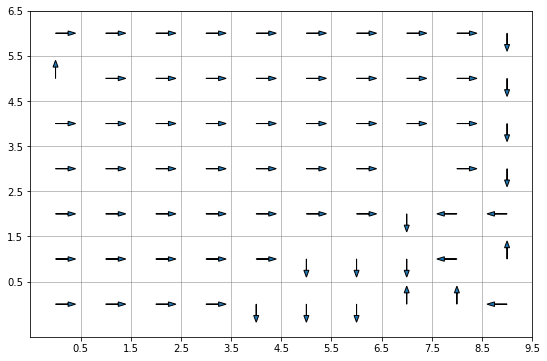

In [102]:
arrows = {"E":(1,0), "W":(-1,0),"N":(0,1),"S":(0,-1)}
scale = 0.25
fig, ax = plt.subplots(figsize=(9, 6))
for r, row in enumerate(policy_td):
    for c, cell in enumerate(row):
        if (r,c) == (3,7):
            continue
        
        plt.arrow(c, 6-r, scale*arrows[cell.name][0], scale*arrows[cell.name][1], head_width=0.1)
        

ax.set_xticks([i + 0.5 for i in range(len(policy_td[0]))])
ax.set_yticks([i + 0.5 for i in range(len(policy_td))])

ax.grid(True, which='both', color='gray', linewidth=1, linestyle='-', alpha=0.5)

print("wind: ", wind)
print("Policy after 100 episodes")

In [103]:
print("V_table after 100 episodes:")
for row in V_table_td:
    for val in row:
        print(f"{val:.3f}", end=" "*(10-len(f"{val:.3f}")))
    print()  # Nowy wiersz
print()  # Nowa linia między siatkami

V_table after 100 episodes:
-7.874    -7.780    -7.588    -7.333    -7.117    -6.811    -6.177    -5.724    -5.291    -4.844    
-7.947    -7.925    -7.584    -7.299    -7.143    -6.621    -6.597    -5.819    -5.290    -4.271    
-8.020    -7.863    -7.616    -7.377    -7.048    -7.016    -6.287    -4.261    -4.485    -3.829    
-8.119    -7.946    -7.745    -7.442    -7.274    -6.685    -6.557    0.000     -4.327    -3.089    
-7.988    -7.808    -7.636    -7.485    -7.016    -6.852    0.000     -1.136    -1.000    -1.900    
-7.850    -7.684    -7.516    -7.293    -7.252    0.000     0.000     -2.094    -2.288    -2.924    
-7.756    -7.682    -7.596    -7.473    0.000     0.000     0.000     0.000     -2.340    -2.792    



Po 100 epizodach jest całkowicie optymalny.

## Reprodukcja wykresu

In [115]:
# Random starting policy (deterministic!)
policy_td = [[np.random.choice(list(Action)) for i in range(10)] for j in range(7)]
# V_table[wiersz][kolumna]
V_table_td = [[0.0 for j in range(10)] for k in range(7)]

In [116]:
t = train_policy_td(n_episodes=150)

In [117]:
import seaborn as sns

/Users/hubert/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


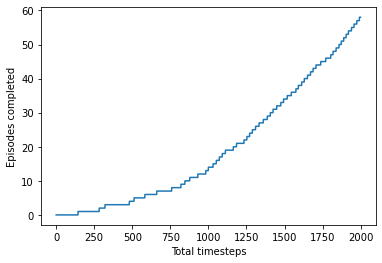

In [122]:
x = [i for i in range(2000)]
sns.lineplot(x, t)
plt.ylabel("Episodes completed")
plt.xlabel("Total timesteps")
plt.show()